# Class 2: Optimization

Optimization is a general topic, and not specific to LCA. Please read through the following to get a detailed introduction on optimization:

[Gaël Varoquaux - Scipy Lectures - Mathematical optimization](http://www.scipy-lectures.org/advanced/mathematical_optimization/)

# Setup

In [1]:
from brightway2 import *

Some more imports

In [2]:
from stats_arrays import *
import numpy as np

We assume that you have [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/) installed already. If you don't:

    conda install -y -q seaborn

In [3]:
%matplotlib inline

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

Copy our first project which included ecoinvent 2.2.

In [5]:
# projects.current = "Class 1"
# projects.copy_project("Class 2")

Make sure we have the right project, and that things are set up the way we want them.

In [6]:
projects.current = "Class 2"

So, we are going to make a model of transport choices, and optimize for the subsidy that should be given to ebike purchases. Please note that this is a **toy model**, and the results will be completely wrong. Let's start by making some simple assumptions:

In [7]:
avg_distance = 36.7           # km
population = 10000            # people
days = 10 * 250               # years * days/year
costs = {
    "electricity": 0.05,      # CHF/km
    "ebike": 7.5e3,           # CHF over 10 years, including maintenance
    "new car km": 0.25,       # CHF/km
    "new car": 1.5e4,         # CHF over 10 years, less resale
    "old car km": 0.3,        # CHF/km
    "bike maintenance": 500,  # CHF over 10 years
    "old car resale": 2.5e3,  # CHF
    "car sharing": 0.6,       # CHF/km
    "green penalty": 5e3,     # CHF
    "postbus": 0.4,           # CHF/km
}

Set up our system. Our median distance values come from the [2010 microcensus](http://www.bfs.admin.ch/bfs/portal/en/index/themen/11/04/blank/03.html), but the distribution is made up.

In our model, each person travels their distance each day.

In [8]:
class SystemSetup(object):
    def __init__(self):
        self.distance_params, self.distances = self.get_distances()
        self.trips = self.get_trips()
        self.bikes = self.when_bike_possible()
        self.ebikes = self.when_ebike_possible()
        # Following the microcensus, there is a 0.7 chance that one has a bicycle, and a 0.8 chance that one has a car. We will assign these at random.
        self.has_bicycle = np.random.random(size=population) < 0.7
        self.has_car = np.random.random(size=population) < 0.8
        # Each trip has an 0.8 chance of being possible using public transport.
        self.can_use_ov = (np.random.random(size=(population * 5))
                                    .reshape(self.ebikes.shape)) < 0.8
        # There are also 20% of the population that are against cars, 
        # and will pay an additional penalty for private car use.
        self.against_cars = np.random.random(size=population) < 0.2
    
    def get_distances(self):
        params = LognormalUncertainty.from_dicts(
            {
                'loc': np.log(avg_distance),
                'scale': 1,
                'maximum': 200,
            }
        )
        distances = LognormalUncertainty.bounded_random_variables(params, size=population).ravel()
        return params, distances

    def get_trips(self):
        """Figure out how many trips people take - they can take a different vehicle for each trip. Assume that everyone can take between 1 and 5 trips. We will split up the distances randomly."""
        trips = (np.random.random(size=(population* 5))
                          .reshape((population, 5)))
        trips_occured = ((np.random.random(size=(population * 4)) > 0.5)    
                                  .reshape((population, 4))) * 1
        # At least one trip, and the others are random
        trips[:, 1:] = trips[:, 1:] * [trips_occured]        
        # Normalize so that each person sums to one
        trips = trips / trips.sum(axis=1).reshape((-1, 1))
        # And multiply by each persons total distance
        trips *= self.distances.reshape((-1, 1))
        print("Total number of actual trips:", (trips > 0).sum())
        return trips

    def when_bike_possible(self):
        """We assume that the fraction of trips taken by bicycle goes down linearly with distance to 25 km. 
        There is also only an 0.7 chance that any given trip possible with bike or electric bike will be 
        taken due to e.g. weather."""
        chance_bicycle = (1 - self.trips / 25) * 0.7
        # Eliminate non-trips where distance = 0
        chance_bicycle[chance_bicycle == 0.7] = 0 
        # Turn probabilities into boolean array of possible true or falses
        chance_bicycle = (chance_bicycle > np.random.random(size=(population * 5))
                                                    .reshape(chance_bicycle.shape)) 
        print("Bikes can be used on this many trips:", chance_bicycle.sum())
        return chance_bicycle

    def when_ebike_possible(self):
        """Similar to above - ebikes can be used up to 70 km."""
        chance_ebike = (1 - self.trips / 70) * 0.7
        chance_ebike[chance_ebike == 0.7] = 0
        chance_ebike = (chance_ebike > np.random.random(size=(population * 5))
                                                .reshape(chance_ebike.shape)) 
        print("EBikes can be used on this many trips:", chance_ebike.sum())
        return chance_ebike


In [9]:
system_setup = SystemSetup()

Total number of actual trips: 30171
Bikes can be used on this many trips: 11281
EBikes can be used on this many trips: 16594


We want to understand some of the values we just created, so we graph them.

In [10]:
class Graphics(object):
    def graph_distances(self, params, distances):
        plt.plot(*LognormalUncertainty.pdf(params, np.linspace(0, 200, 1e4)), label="Predicted")
        plt.xlabel("Distance")
        plt.ylabel("Probability")

        sns.distplot(distances, label="Observed")
        plt.legend()
        plt.xlim(0, 200)
        plt.tight_layout()

    def graph_trips(self, trips):
        f, axes = plt.subplots(1, 2, figsize=(12, 6))

        num_trips = axes[0]
        trip_hist = axes[1]

        mask = trips > 0

        sns.distplot(mask.sum(axis=1), kde=False, ax=num_trips)
        num_trips.set_title("Number of trips per person (count)")

        sns.distplot(trips[mask], color="g", ax=trip_hist)
        trip_hist.set_title("Trip distances (km)")
        trip_hist.set_xlim(0, 100)

        plt.setp(axes, yticks=[])
        plt.tight_layout()

    def graph_options(self, te):
        sns.violinplot(data=te.evalulate_all_options(10000.))
        sns.despine(left=True)
        plt.ylabel("Total cost")
        plt.xticks(range(6), te.labels)
        plt.tight_layout()        

    def graph_by_cost(self, te):
        for label, options in zip(te.labels, te.option_kwargs):
            plt.figure(figsize=(10, 6))
            plt.title(label)
            sns.violinplot(data=te.calculate_costs(te.allocate_transport(**options), 10000., split=True))
            sns.despine(left=True)
            plt.ylabel("Total cost")
            plt.xticks(
                range(10), 
                ["Bike", "Buy Ebike", "Run Ebike", "Buy car", "Run new car", "Run old car", "Sell car", "Green tax", "Postbus", "Mobility"]
            )
            plt.tight_layout()        

    def graph_choices(self, te):
        choices = te.choose_best_option(te.evalulate_all_options(0.))

        plt.hist(choices, bins=np.arange(-0.5, 5.5, 1))
        plt.xticks(range(6), te.labels)
        plt.xlim(-1, 6)
        plt.ylabel("Count")
        plt.tight_layout()

    def graph_costs_curve(self, te):
        xs = np.linspace(0, 25000, 100)
        results = [te.best_model_result(x) for x in xs]

        ys1 = [obj[1].sum() for obj in results]
        ys2 = [obj[0].ebike_bought.sum() * premium for premium, obj in zip(xs, results)]
        ys3 = [te(x) for x in xs]

        plt.plot(xs, ys1, label="Individual costs")
        plt.plot(xs, ys2, 'g-', label="Subsidy total")
        plt.plot(xs, ys3, 'r-', label="Total")
        plt.legend(loc=6)
        plt.ylabel("Costs (CHF)")
        plt.xlabel("Subsidy per electric bike (CHF)")        


graphics = Graphics()

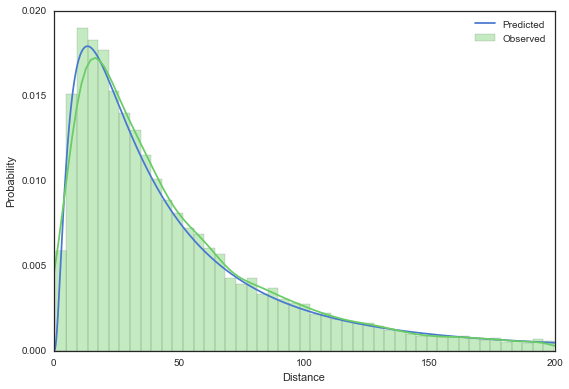

In [11]:
graphics.graph_distances(system_setup.distance_params, system_setup.distances)

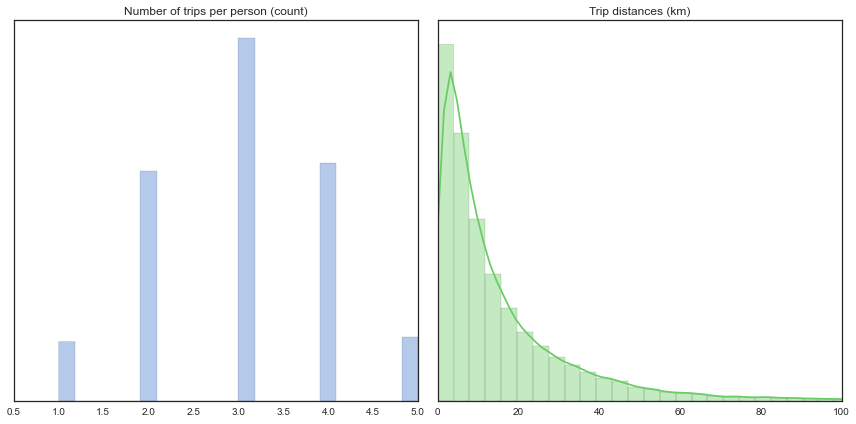

In [12]:
graphics.graph_trips(system_setup.trips)

We define a data structure to store our model results

In [13]:
import collections

fields = (
    "bike_used", 
    "ebike_bought", 
    "ebike_used", 
    "new_car_bought", 
    "new_car_used", 
    "old_car_sold", 
    "old_car_used", 
    "ov_used", 
    "car_sharing_used",
)

ModelResult = collections.namedtuple('ModelResult', fields)

We now define our model (finally!). Actually, this is the easy part - most of the work in optimization is getting the input data in a reasonable state, and checking your assumptions. Well, and doing sensitivity analysis of your input parameters, uncertainty analysis of your results, and then choosing algorithms... there are a lot of "most of the work" elements, I guess.

Our model will be semi-agent based. Each person will evaluate all possible options, and choose the lowest cost for their preferences and trip schedule. The options are:

1. Buy new car + sell old car
2. Buy electric bicycle

We assume that if you don't have a bicycle already, you don't want one.

However, for each trip we will still need to choose between old car, new car, bicycle, electric bicycle, car share, and public transport.

In [14]:
class TransportEvaluator(object):
    def __init__(self, costs, setup):
        """Set up model with input parameters, and calculate preliminary cost arrays"""
        self.distances = setup.trips            # 2-d array; population by trips
        self.costs = costs                      # dictionary
        self.has_bicycle = setup.has_bicycle    # Boolean array; 1-d (population)
        self.has_car = setup.has_car            # Boolean array; 1-d (population)
        self.ov_trips = setup.can_use_ov        # Boolean array; can use public transport; population by trips
        self.bike_trips = setup.bikes           # Boolean array; can use bike; population by trips
        self.ebike_trips = setup.ebikes         # Boolean array; can use bike; population by trips
        self.against_cars = setup.against_cars  # Boolean array; 1-d (population)

        self.labels = [
            "New car", 
            "Sell car", 
            "Sell car, buy ebike", 
            "Buy all", 
            "Buy ebike", 
            "Status Quo"
        ]

        self.option_kwargs = [
            {"buy_new_car": True},
            {"sell_car": True},
            {"sell_car": True, "buy_ebike": True},
            {"buy_new_car": True, "buy_ebike": True},
            {"buy_ebike": True},
            {}
        ]
    
        self.options = self.calculate_all_options()

    def __call__(self, ebike_premium=0.):
        """Call the model. 

        ``ebike_premium`` is financial incentive offered to ebike purchase."""
        mr, costs = self.best_model_result(ebike_premium)
        return costs.sum() + mr.ebike_bought.sum() * ebike_premium

    def choose_best_option(self, options):
        return np.argsort(np.hstack(options).reshape((6, -1)), axis=0)[0, :]

    def construct_empty_model_result(self):
        return ModelResult(
            np.zeros(self.distances.shape, dtype=bool),
            np.zeros(self.distances.shape[0], dtype=bool),
            np.zeros(self.distances.shape, dtype=bool),
            np.zeros(self.distances.shape[0], dtype=bool),
            np.zeros(self.distances.shape, dtype=bool),
            np.zeros(self.distances.shape[0], dtype=bool),
            np.zeros(self.distances.shape, dtype=bool),
            np.zeros(self.distances.shape, dtype=bool),
            np.zeros(self.distances.shape, dtype=bool),
        )

    def add_rows(self, in_mr, out_mr, mask):
        one_d_attrs = ["ebike_bought", "new_car_bought", "old_car_sold"]
        two_d_attrs = ["bike_used", "ebike_used", "new_car_used", "old_car_used", "ov_used", "car_sharing_used"]
        for attr in one_d_attrs:
            getattr(out_mr, attr)[mask] = getattr(in_mr, attr)[mask]
        for attr in two_d_attrs:
            getattr(out_mr, attr)[mask, :] = getattr(in_mr, attr)[mask, :]

    def best_model_result(self, premium):
        all_costs = self.evalulate_all_options(premium)
        choices = self.choose_best_option(all_costs)
        costs = np.hstack(all_costs).reshape((6, -1))[choices, np.arange(choices.shape[0])]
        result = self.construct_empty_model_result()

        for index in range(6):
            mask = choices == index
            self.add_rows(self.options[index], result, mask)

        return result, costs

    def calculate_all_options(self):
        return [self.allocate_transport(**kwargs) for kwargs in self.option_kwargs]

    def evalulate_all_options(self, premium):
        return [self.calculate_costs(obj, premium) for obj in self.options]

    def calculate_costs(self, mr, premium, split=False):
        """Calculate costs for a model result. 

        Premium is subtracted from each ebike purchase price."""
        values = [
            # Bicycle maintenance
            (mr.bike_used.sum(axis=1) > 0) * self.costs['bike maintenance'],
            # Ebike cost, including maintenance
            mr.ebike_bought.astype(float) * (self.costs['ebike'] - premium), 
            # Ebike operating cost
            (mr.ebike_used * self.distances).sum(axis=1) * self.costs['electricity'] * days,
            # New car purchase
            mr.new_car_bought * self.costs['new car'],
            # New car operating cost
            (mr.new_car_used * self.distances).sum(axis=1) * self.costs['new car km'] * days,
            # Old car operating cost
            (mr.old_car_used * self.distances).sum(axis=1) * self.costs['old car km'] * days,
            # Old car resale
            -1 * mr.old_car_sold * self.costs['old car resale'],
            # Car penalty
            ((mr.old_car_used + mr.new_car_used).sum(axis=1) > 0) * self.against_cars * self.costs['green penalty'],
            # Public transport
            (mr.ov_used * self.distances).sum(axis=1) * self.costs['postbus'] * days,
            # Car sharing
            (mr.car_sharing_used * self.distances).sum(axis=1) * self.costs['car sharing'] * days
        ]
        if split:
            return values
        else:
            return sum(values)

    def allocate_transport(self, buy_new_car=False, buy_ebike=False, sell_car=False):
        """Allocate transport using precedence order list.

        Choose transport from the lowest to highest cost, namely:

        * bike
        * electric bike
        * new car
        * old car
        * public transport
        * car sharing

        ebike is only available if ``buy_ebike``.
        new car is only available if ``buy_new_car``.
        new and old car are removed if ``sell_car``.

        This is a silly algorithm, but the whole model is made up, so...

        """
        # If bicycle available, use bicycle when possible
        trips = self.distances.copy()

        bike_used = np.ones(shape=trips.shape, dtype=bool)
        bike_used[~self.has_bicycle, :] = False  # No bike, can't use it
        bike_used[~self.bike_trips] = False      # Trip not suitable for bike
        trips[bike_used] = 0

        # Buy and use ebike, if possible
        if buy_ebike:
            ebike_used = self.ebike_trips * ~bike_used
            trips[ebike_used] = 0
        else:
            ebike_used = self.ebike_trips * False

        if not sell_car:
            if buy_new_car:
                new_car_used = trips.astype(bool)
                old_car_used = trips.astype(bool) * False
                trips = trips.astype(bool) * False
            else:
                new_car_used = trips.astype(bool) * False
                old_car_used = trips.astype(bool) * self.has_car.reshape((-1, 1))
                trips[old_car_used] = 0

        else:
            old_car_used = trips.astype(bool) * False
            new_car_used = trips.astype(bool) * False

        ov = trips.astype(bool) * self.ov_trips
        trips[ov] = 0
        mobility = trips.astype(bool)  # All remaining

        return ModelResult(
            bike_used,
            ebike_used.sum(axis=1) > 0,
            ebike_used,
            new_car_used.sum(axis=1) > 0,
            new_car_used,
            self.has_car * (True if (sell_car or buy_new_car) else False),
            old_car_used, 
            ov,
            mobility
        )


In [15]:
te = TransportEvaluator(costs, system_setup)

In [16]:
np.array([True, False]) * ~np.array([False, True])

array([ True, False], dtype=bool)

In [17]:
system_setup.bikes.sum(), system_setup.ebikes.sum()

(11281, 16594)

In [18]:
system_setup.ebikes.shape, system_setup.trips.shape

((10000, 5), (10000, 5))

Let's investigate how much the different options cost.

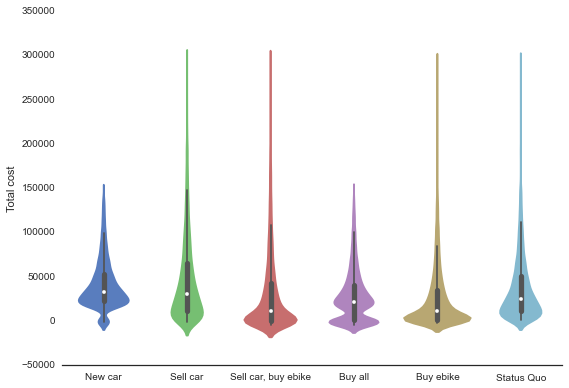

In [19]:
graphics.graph_options(te)

Why do the ebike options cost so much?

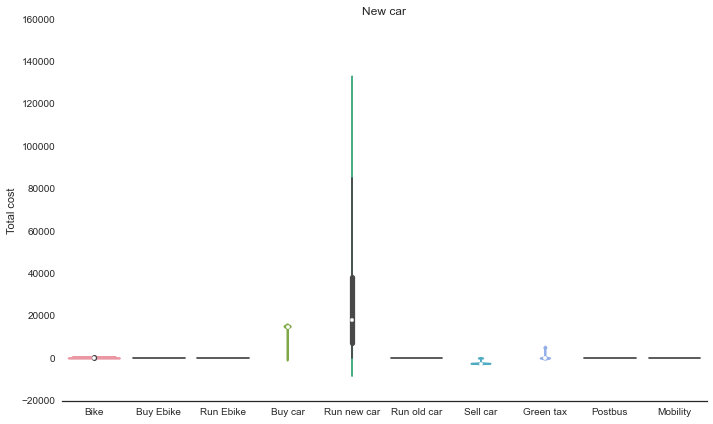

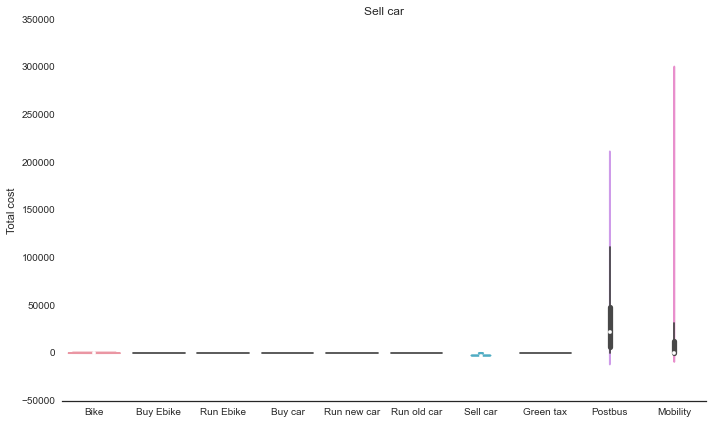

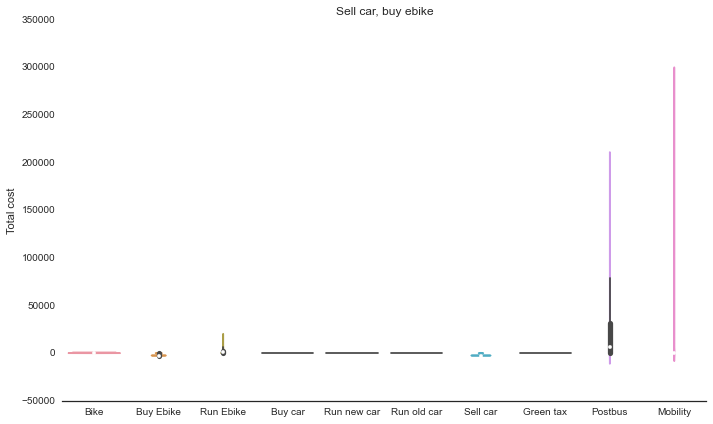

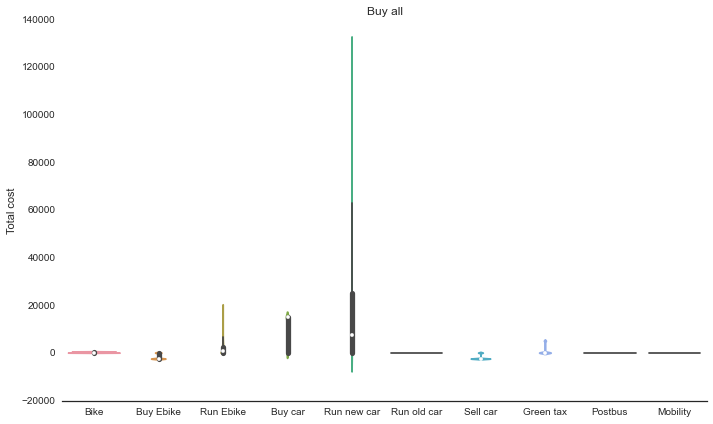

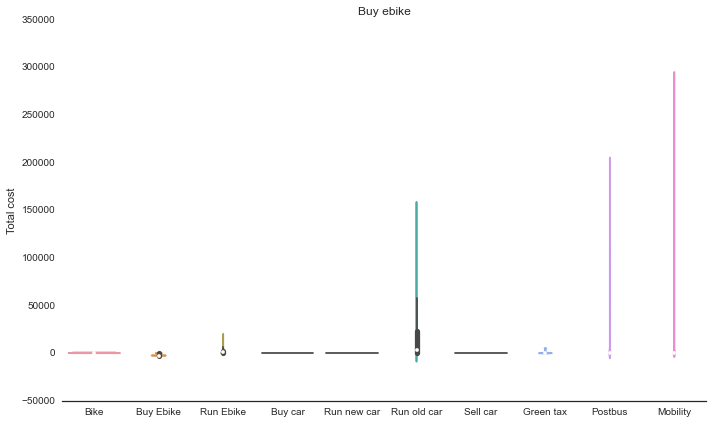

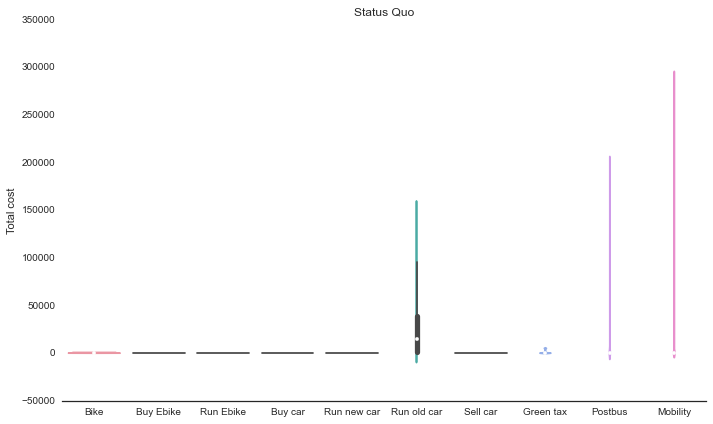

In [20]:
graphics.graph_by_cost(te)

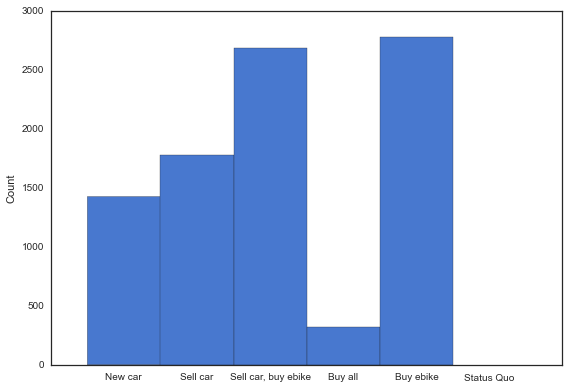

In [21]:
graphics.graph_choices(te)

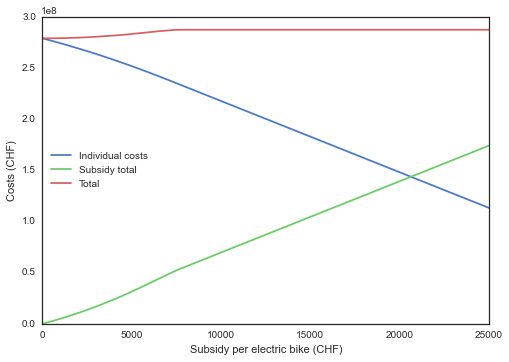

In [22]:
graphics.graph_costs_curve(te)

We can change some assumptions and see how the model reacts.

Let's change the cost of the old car to 0.5 CHF/km

Total number of actual trips: 29904
Bikes can be used on this many trips: 11171
EBikes can be used on this many trips: 16399


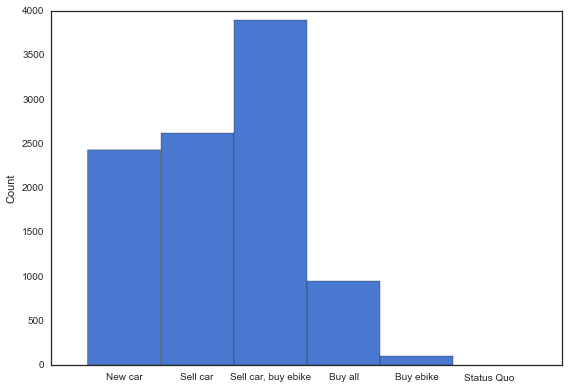

In [23]:
costs["old car km"] = 0.5

te = TransportEvaluator(costs, SystemSetup())

graphics.graph_choices(te)

Now, let's assume people travel more (and switch the old car cost back to its previous value):

Total number of actual trips: 30061
Bikes can be used on this many trips: 8001
EBikes can be used on this many trips: 14244


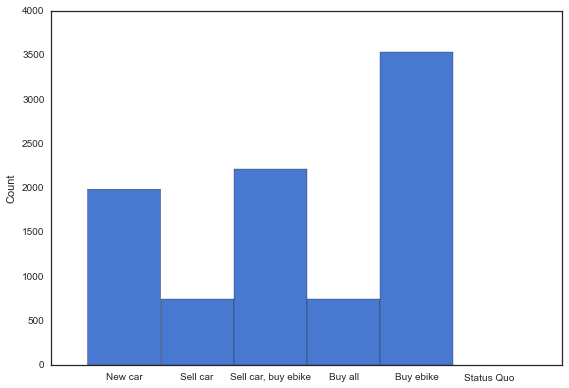

In [24]:
avg_distance = 75
costs["old car km"] = 0.3

te = TransportEvaluator(costs, SystemSetup())

graphics.graph_choices(te)

We return to our initial assumptions

In [25]:
avg_distance = 36.7
te = TransportEvaluator(costs, SystemSetup())

Total number of actual trips: 29786
Bikes can be used on this many trips: 11013
EBikes can be used on this many trips: 16278


And now we can finally do some optimization!

In [26]:
from scipy.optimize import minimize

minimize(te, 5000., bounds=[[0, 1e6]])

     jac: array([ 0.])
 message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nit: 0
     fun: array([  2.87143682e+08])
  status: 0
 success: True
       x: array([ 5000.])
    nfev: 2

Can play around here with entering bounds and or constraints. 

One could also edit the `__call__` method to ignore values less than zero.

In [27]:
minimize(te, 6000., method="Powell", bounds=[[0, 1e6]])

   direc: array([[ 1.]])
 message: 'Optimization terminated successfully.'
     nit: 1
     fun: array(288843639.59776604)
  status: 0
 success: True
       x: array(6002.587928961546)
    nfev: 13

Play around with this bit for a while. See the [SciPy optimize docs](http://docs.scipy.org/doc/scipy/reference/optimize.html).

For the next step, we want to also consider environmental impacts. We will do this in a simplified fashion.

In [28]:
class EnvironmentalImpacts(object):
    def __init__(self):
        self.db = Database("ecoinvent 2.2")
        self.get_datasets()
        self.method = ('IPCC 2013', 'climate change', 'GWP 100a')
        self.lca = LCA({self.bike: 1}, method=self.method)
        self.lca.lci(factorize=True)
        self.lca.lcia()

    def get_datasets(self):
        self.bike = self.db.search("transport, bicycle")[0]
        assert self.bike['name'] == 'transport, bicycle'

        self.ebike = self.db.search("transport, electric bicycle")[0]
        assert self.ebike['name'] == 'transport, electric bicycle'

        self.euro3 = self.db.search("transport passenger petrol euro3")[0]
        assert self.euro3['name'] == 'transport, passenger car, petrol, EURO3'

        self.euro5 = self.db.search("transport passenger petrol euro5")[0]
        assert self.euro5['name'] == 'transport, passenger car, petrol, EURO5'

        self.train = self.db.search("passenger train sbb")[0]
        assert self.train['name'] == 'operation, average train, SBB mix'

    def evaluate_for_method(self, te, premium, method=None):
        if method is not None:
            self.lca.method = method
            self.lca.load_lcia_data()

        mr, costs = te.best_model_result(premium)

        total = 0

        # print("Bike distances:", (mr.bike_used * te.distances).sum())
        # print("Ebike distances:", (mr.ebike_used * te.distances).sum())
        # print("New car distances:", (mr.new_car_used * te.distances).sum())
        # print("Old car distances:", (mr.old_car_used * te.distances).sum())
        # print("Public transport distances:", (mr.ov_used * te.distances).sum())
        # print("Car sharing distances:", (mr.car_sharing_used * te.distances).sum())
        # print("Total distance:", (mr.bike_used + mr.ebike_used + mr.new_car_used + mr.old_car_used + mr.ov_used + mr.car_sharing_used).sum())

        self.lca.redo_lcia({self.bike: (mr.bike_used * te.distances).sum()})
        total += self.lca.score

        self.lca.redo_lcia({self.ebike: (mr.ebike_used * te.distances).sum()})
        total += self.lca.score


        self.lca.redo_lcia({self.euro5: (mr.new_car_used * te.distances).sum()})
        total += self.lca.score


        self.lca.redo_lcia({self.euro5: (mr.car_sharing_used * te.distances).sum()})
        total += self.lca.score

        self.lca.redo_lcia({self.euro3: (mr.old_car_used * te.distances).sum()})
        total += self.lca.score

        self.lca.redo_lcia({self.train: (mr.ov_used * te.distances).sum()})
        total += self.lca.score

        return total

env_impacts = EnvironmentalImpacts()

Get some LCIA methods

In [33]:
gwp = ('IPCC 2013', 'climate change', 'GWP 100a')
resources = ('ReCiPe Endpoint (E,A)', 'resources', 'total')
metals = ('ReCiPe Endpoint (E,A)', 'resources', 'metal depletion')

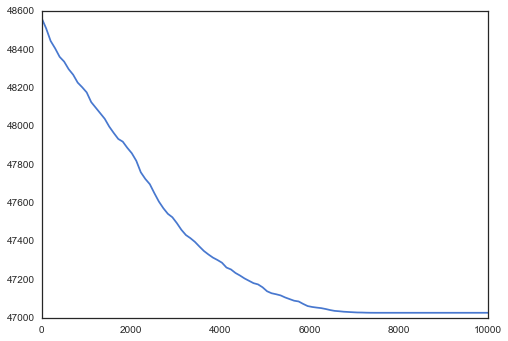

In [29]:
xs = np.linspace(0, 10000, 100)
ys = [env_impacts.evaluate_for_method(te, x) for x in xs]
plt.plot(xs, ys)

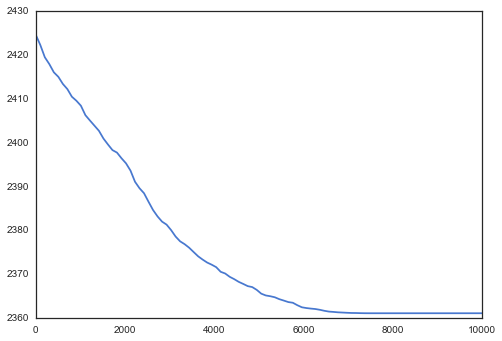

In [34]:
xs = np.linspace(0, 10000, 100)
ys = [env_impacts.evaluate_for_method(te, x, resources) for x in xs]
plt.plot(xs, ys)

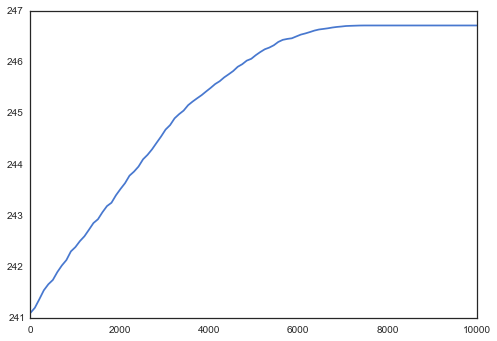

In [35]:
xs = np.linspace(0, 10000, 100)
ys = [env_impacts.evaluate_for_method(te, x, metals) for x in xs]
plt.plot(xs, ys)